In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
from jaxoptics.fields import ScalarField, normalize_power
from jaxoptics import hermite_gaussian_groups, generate_mode_stack, Gaussian, HermiteGaussian
from jaxoptics import GridLayout, TriangleLayout
from jaxoptics import ASProp, Phase, OpticalSequence
from jaxoptics import visualize_stack
import matplotlib.pyplot as plt

In [3]:
print(jax.devices())

[CudaDevice(id=0)]


In [4]:
shape = (512, 512)
ds = (2e-6, 2e-6)
wavelength = 1.064e-6

# centers = [(0, 100e-6), (100e-6, 0), (0, 0)]
centers = TriangleLayout(2, px=200e-6, py=200e-6, offset=(0,-50e-6), rotation=3*jnp.pi/4)

w0 = 100e-6
n_groups = 2

modes = generate_mode_stack(hermite_gaussian_groups(n_groups, w0), shape, ds, centers=centers, rotation=3*jnp.pi/4)

In [5]:
u0 = ScalarField(modes, ds, wavelength)
u0 = normalize_power(u0)

u0.power

Array([1., 1., 1.], dtype=float32)

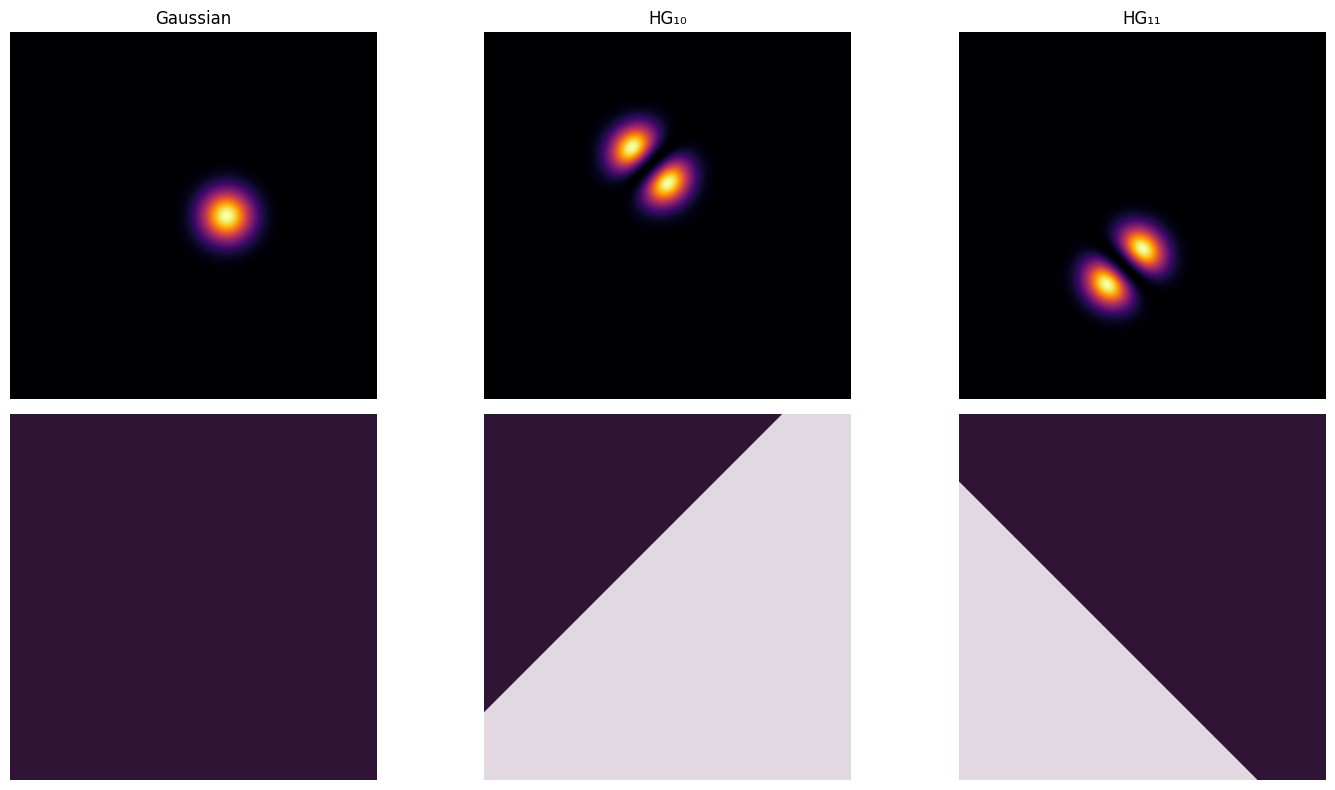

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
titles = ['Gaussian', 'HG₁₀', 'HG₁₁']

for i, title in enumerate(titles):
    axes[0, i].imshow(jnp.abs(u0.electric[i])**2, cmap='inferno')
    axes[0, i].set_title(title)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(jnp.angle(u0.electric[i]), cmap='twilight', vmin=-jnp.pi, vmax=jnp.pi)
    axes[1, i].axis('off')

plt.tight_layout()

In [7]:
phase = Phase(u0, init_fn=lambda x, y: -jnp.pi * (x**2 + y**2) / 1e-6 / 20e-3, trainable=True)

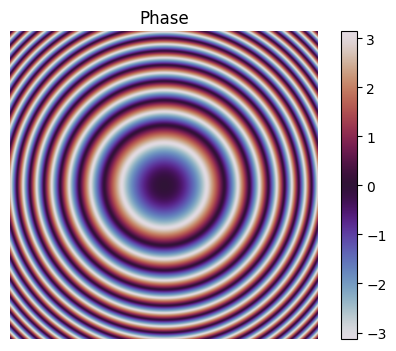

In [8]:
plt.figure(figsize=(6, 4))
plt.imshow(jnp.angle(jnp.exp(1j*phase.phase_mask)), cmap='twilight')
plt.axis('off')
plt.colorbar()
plt.title(f'Phase')
plt.show()

In [9]:
prop = ASProp(u0, z=10e-3, use_cache=True, paraxial=False)
system = OpticalSequence(prop, phase, prop)

In [10]:
uf = eqx.filter_jit(system)(u0)

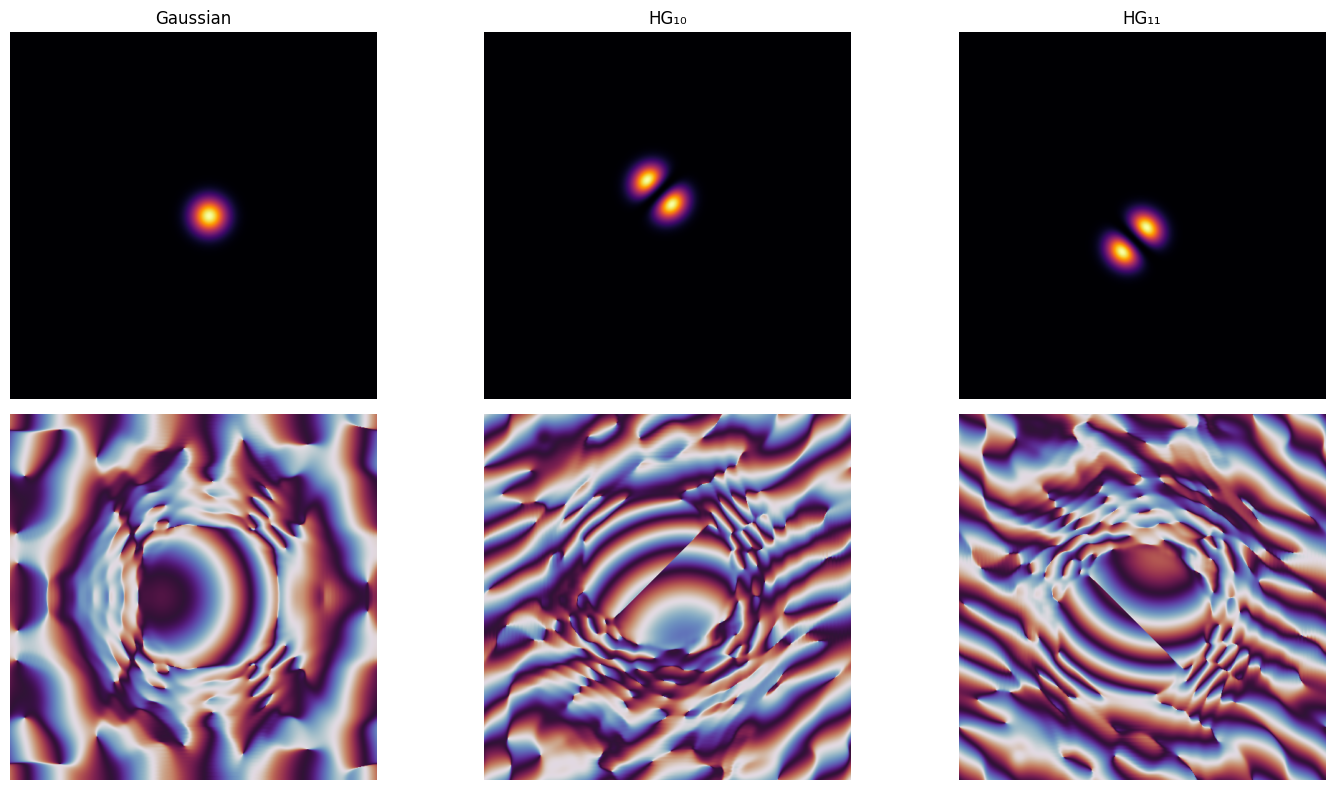

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
titles = ['Gaussian', 'HG₁₀', 'HG₁₁']

for i, title in enumerate(titles):
    axes[0, i].imshow(jnp.abs(uf.electric[i])**2, cmap='inferno')
    axes[0, i].set_title(title)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(jnp.angle(uf.electric[i]), cmap='twilight', vmin=-jnp.pi, vmax=jnp.pi)
    axes[1, i].axis('off')

plt.tight_layout()

In [12]:
@jax.jit
def apply_prop(u):
    return system(u)

uf = apply_prop(u0)

In [13]:
no_optim = optax.set_to_zero()

def label_fn(model):
    if isinstance(model, OpticalSequence):  
        # Recursively apply label_fn on each layer while preserving structure
        return OpticalSequence(*map(label_fn, model.optical_components))
    elif isinstance(model, Phase):
        if model.is_trainable:
            return eqx.tree_at(lambda layer: layer.phase_mask, model, "phase_mask")
        else:
            return eqx.tree_at(lambda layer: layer.phase_mask, model, "frozen")
    elif isinstance(model, ASProp):
        if model.use_cache:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), model, ("frozen", "frozen"))
        else:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), model, ("frozen", "as_prop_z"))
    else:
        return jax.tree_map(lambda _: "frozen", model)

In [14]:
label_fn(system)

OpticalSequence(
  optical_components=(
    ASProp(
      kernel='frozen',
      z='frozen',
      filter_fn=None,
      use_cache=True,
      is_paraxial=False,
      n0=1.0
    ),
    Phase(phase_mask='phase_mask', is_trainable=True),
    ASProp(
      kernel='frozen',
      z='frozen',
      filter_fn=None,
      use_cache=True,
      is_paraxial=False,
      n0=1.0
    )
  )
)

In [15]:
tx = optax.transforms.partition({"phase_mask": optax.nadam(0.1), "as_prop_z": optax.nadam(1e-5), "frozen":no_optim}, label_fn)
opt_state = tx.init(system)

In [16]:
opt_state

PartitionState(inner_states={'phase_mask': MaskedState(inner_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=OpticalSequence(
  optical_components=(
    ASProp(
      kernel=MaskedNode(),
      z=MaskedNode(),
      filter_fn=None,
      use_cache=True,
      is_paraxial=False,
      n0=1.0
    ),
    Phase(phase_mask=f32[512,512], is_trainable=True),
    ASProp(
      kernel=MaskedNode(),
      z=MaskedNode(),
      filter_fn=None,
      use_cache=True,
      is_paraxial=False,
      n0=1.0
    )
  )
), nu=OpticalSequence(
  optical_components=(
    ASProp(
      kernel=MaskedNode(),
      z=MaskedNode(),
      filter_fn=None,
      use_cache=True,
      is_paraxial=False,
      n0=1.0
    ),
    Phase(phase_mask=f32[512,512], is_trainable=True),
    ASProp(
      kernel=MaskedNode(),
      z=MaskedNode(),
      filter_fn=None,
      use_cache=True,
      is_paraxial=False,
      n0=1.0
    )
  )
)), EmptyState())), 'as_prop_z': MaskedState(inner_state=(ScaleByAdamState(count=

In [18]:
%matplotlib qt5
visualize_stack(u0.electric)

In [23]:
plt.close('all')
%matplotlib inline